<a href="https://colab.research.google.com/github/phisan-chula/Construction_Survey/blob/main/Geod_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%%capture
! pip install PyGeodesy
! pip install lmfit

In [12]:
! wget -nc Murat_Demitry_Comp2011.yaml  https://raw.githubusercontent.com/phisan-chula/Construction_Survey/main/GeodeticNetwork/Murat_Demitry_Comp2011.yaml
! cat Murat_Demitry_Comp2011.yaml 

--2022-10-24 02:55:04--  http://murat_demitry_comp2011.yaml/
Resolving murat_demitry_comp2011.yaml (murat_demitry_comp2011.yaml)... failed: Name or service not known.
wget: unable to resolve host address ‘murat_demitry_comp2011.yaml’
File ‘Murat_Demitry_Comp2011.yaml’ already there; not retrieving.

#
# Adjustment of Planned Surveying and Geodetic Networks
#Using Second-Order Nonlinear Programming Methods
#Murat Mustafin and Dmitry Bykasov
#  MDPI compuation : 2022
#
#
#

WEIGHT :
        - [ANG  , 20   ]   # sec
        - [DIST , 0.02 ]    #  meter
        - [DIR ,  1  ]      # sec


FIX_PNT:
        - [ A, 645.112,   426.229 ]
        - [ B, 1028.568,  857.277 ]
        - [ C, 740.339,  1333.496 ]

NEW_PNT:
        - [ P1, 210.0000, 1235.000 ]
        - [ P2, 575.0000, 869.000 ]
        - [ P3, 150.0000, 580.000 ]
        - [ P4, -135.0000, 950.000 ]
        - [ P5, 40.0000, 285.000 ]
 
DIST: 
    - [ C , P2, 492.886 ]
    - [ B , P2, 448.178 ]
    - [ A , P2, 445.726 ]
    - [ A , P

In [13]:
#
# Geod_netw : geodetic network solver by (lmfit) least square adjustment
#               computation The geodetic network could be intersection,
#               resection and traverse.
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Minimizer, Parameters, report_fit
from pygeodesy.dms import toDMS, parseDMS
import sys
from pathlib import Path
import yaml

def Azi2PI ( FR_TO ):
    FR,TO = FR_TO
    return divmod( np.arctan2( TO[0]-FR[0] , TO[1]-FR[1] ), 2*np.pi )[1]

def Ang2PI( BS_STA_FS ):
    BS,STA,FS = BS_STA_FS
    azBS, azFS = Azi2PI([STA,BS]) ,Azi2PI([STA,FS])
    ang =  divmod( azFS-azBS,  2*np.pi )[1]
    return ang

def Dist( FR_TO ):
    FR,TO = FR_TO
    return np.hypot( TO[0]-FR[0] , TO[1]-FR[1] )

#########################################################################
class TriangularAdj:
    def __init__(self, YAML, METHOD='leastsq'):
        self.METHOD = METHOD
        with open(YAML, mode='r') as f:
            YAML = yaml.safe_load( f )
        #print( YAML.keys() ); print( YAML )
        NEW_PNT = pd.DataFrame(YAML['NEW_PNT'],columns=['Name','X','Y'] )
        FIX_PNT = pd.DataFrame(YAML['FIX_PNT'],columns=['Name','X','Y'] )
        NEW_PNT['Type'] = 'NEW' ; FIX_PNT['Type'] = 'FIX'
        self.dfALL_PNT = pd.concat([NEW_PNT,FIX_PNT],ignore_index=True)
        if 'WEIGHT' in YAML.keys():
            self.W = pd.DataFrame( YAML['WEIGHT'] )
            def GetW( CODE):
                return self.W[self.W[0]==CODE].iloc[0][1]
        #################################################################
        OBS_COL1 = ['BS','STA','FS','VALUE']
        OBS_COL2 = ['Type','Unit', 'FUNC' ]
        self.dfOBS = pd.DataFrame( )
        if 'ANG' in YAML.keys():
            dfANG = pd.DataFrame( YAML['ANG'],columns=OBS_COL1)
            if dfANG.dtypes['VALUE']=='object':  # "ddd:mm:ss.sss"
                def ToRad( arg ):
                    return np.radians( parseDMS( arg,sep=':') )
                dfANG['VALUE'] = dfANG['VALUE'].apply( ToRad )
            else:  # decimal degree format
                dfANG['VALUE'] = self.dfANG['VALUE']
            dfANG[OBS_COL2] = ['ANG','radian', Ang2PI ]
            if 'WEIGHT' in YAML.keys():
                dfANG['Weight'] = 1/( np.radians( GetW('ANG')/3600)**2 )
            self.dfOBS = pd.concat( [ self.dfOBS , dfANG] )
        if 'DIST' in YAML.keys():
            dfDIST = pd.DataFrame( YAML['DIST'], columns=OBS_COL1[1:] )
            dfDIST[['BS']+OBS_COL2] = ['np.nan', 'DIST','meter', Dist ]
            if 'WEIGHT' in YAML.keys():
                dfDIST['Weight'] = 1/ (GetW('DIST')**2 )
            self.dfOBS = pd.concat( [ self.dfOBS , dfDIST] )
        if 'DIR' in YAML.keys():
            dfDIR = pd.DataFrame( YAML['DIR'],columns= OBS_COL1[1:])
            dfDIR['VALUE'] = np.radians( dfDIR['VALUE'] )
            dfDIR[['BS']+OBS_COL2] = ['np.nan', 'DIR','radian', Azi2PI ]
            if 'WEIGHT' in YAML.keys():
                dfDIR['Weight'] = 1/( np.radians( GetW('DIR')/3600)**2 )
            self.dfOBS = pd.concat( [ self.dfOBS , dfDIR] )
        self.dfOBS.reset_index( drop=True, inplace=True)
        #################################################################
        UNK_PAR = list()
        for idx,row in NEW_PNT.iterrows():
            for par in [ 'X','Y' ]:
                UNK_PAR.append( [ row['Name'], par, f"{row['Name']}_{par}" ] )
        self.dfPNT_PAR = pd.DataFrame( UNK_PAR,
                              columns=['Name', 'Par', 'UnkPar'] )
        self.YAML = YAML

    def _fcn2min(self, params):
        for idx,row in self.dfPNT_PAR.iterrows(): # update dfPNT
            idx_ = self.dfALL_PNT[ self.dfALL_PNT.Name==row.Name ].index
            self.dfALL_PNT.loc[idx_,row.Par] = params[row.UnkPar].value
        def getPNT( CODE ):
             return  self.dfALL_PNT[
                     self.dfALL_PNT.Name==CODE].iloc[0][['X','Y']].to_list()
        model = list()
        for idx,row in self.dfOBS.iterrows():
            if row.Type == 'ANG':
                ARGS = getPNT(row.BS), getPNT(row.STA), getPNT(row.FS )
            elif row.Type in ['DIST','DIR']:
                ARGS = getPNT(row.STA), getPNT(row.FS )
            else:
                raise Exception('Undefine obseration type "{row.Type}"')
            model.append( row.FUNC( ARGS ) )
        self.dfOBS['model'] = model
        self.dfOBS['residual'] = self.dfOBS['model']-self.dfOBS['VALUE']
        #import pdb; pdb.set_trace()
        if 'WEIGHT' in self.YAML.keys():
            return self.dfOBS['residual']*self.dfOBS['Weight']
        else:
            return self.dfOBS['residual']

    def DoAdjustCompu(self):
        # copy UNK_PNT from self.dfPNT to lmfit/Parameters()
        params = Parameters()
        for idx,row in self.dfPNT_PAR.iterrows():
            val = self.dfALL_PNT[self.dfALL_PNT['Name']\
                                  ==row['Name'] ].iloc[0][row.Par]
            params.add(row.UnkPar, value=val,vary=True )
        # do fit, here with the default leastsq algorithm
        minner = Minimizer( self._fcn2min, params )
        result = minner.minimize( method=self.METHOD )
        return result

    def PlotNet(self, PLOTFILE=None ):
        plt.scatter( self.dfALL_PNT.X, self.dfALL_PNT.Y )
        for idx,row in self.dfALL_PNT.iterrows():
            plt.text( row.X, row.Y, s=row.Name )
        if 'DIST' in self.dfOBS.Type.values:
            for idx,row in self.dfOBS[self.dfOBS.Type=='DIST'].iterrows():
                xy = self.dfALL_PNT[self.dfALL_PNT.Name.isin(
                         [row.STA,row.FS] ) ][['X','Y']].to_numpy()
                plt.plot( xy[:,0], xy[:,1])

        if 'ANG' in self.dfOBS.Type.values:
            for idx,row in self.dfOBS[self.dfOBS.Type=='ANG'].iterrows():
                xy0 = self.dfALL_PNT[self.dfALL_PNT.Name == row.BS  ][['X','Y']].to_numpy()
                xy1 = self.dfALL_PNT[self.dfALL_PNT.Name == row.STA ][['X','Y']].to_numpy()
                xy2 = self.dfALL_PNT[self.dfALL_PNT.Name == row.FS  ][['X','Y']].to_numpy()
                xy = np.vstack( [xy0,xy1,xy2] )
                #import pdb; pdb.set_trace()
                plt.plot( xy[:,0], xy[:,1])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title( PLOTFILE )
        if PLOTFILE is None:
            plt.show()
        else:
            plt.savefig(PLOTFILE)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 14
    # variables        = 10
    chi-square         = 1.04758652
    reduced chi-square = 0.26189663
    Akaike info crit   = -16.2959570
    Bayesian info crit = -9.90538373
[[Variables]]
    P1_X:  213.736097 +/- 1.8268e-04 (0.00%) (init = 210)
    P1_Y:  1241.36788 +/- 2.6301e-04 (0.00%) (init = 1235)
    P2_X:  580.500761 +/- 1.4383e-04 (0.00%) (init = 575)
    P2_Y:  867.247014 +/- 1.4839e-04 (0.00%) (init = 869)
    P3_X:  159.346423 +/- 1.6373e-04 (0.00%) (init = 150)
    P3_Y:  588.653061 +/- 2.6510e-04 (0.00%) (init = 580)
    P4_X: -146.869809 +/- 1.9150e-04 (0.00%) (init = -135)
    P4_Y:  961.205859 +/- 3.4317e-04 (0.00%) (init = 950)
    P5_X:  43.2397962 +/- 2.1620e-04 (0.00%) (init = 40)
    P5_Y:  287.266311 +/- 3.2730e-04 (0.00%) (init = 285)
[[Correlations]] (unreported correlations are < 0.100)
    C(P4_Y, P5_Y) = 0.844
    C(P3_Y, P5_Y) = 0.819
    C(P3_Y, P4_Y

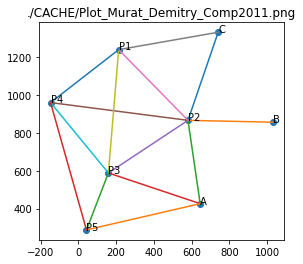

In [14]:
##############################################################################
##############################################################################
##############################################################################
if __name__ == "__main__":
    YAML = '/content/Murat_Demitry_Comp2011.yaml'
    #import pdb; pdb.set_trace()
    TA = TriangularAdj(YAML)
    STEM = Path( YAML ).stem
    PLOTFILE = f'./CACHE/Plot_{STEM}.png'
    ##########################################################################
    res = TA.DoAdjustCompu( )
    print( report_fit(res) )
    print('Parameter    Value       Stderr')
    for name, param in res.params.items():
        if param.stderr is None:
            param.stderr=0.0
        print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')
    print('======================= residual =======================')
    for idx,row in TA.dfOBS.iterrows():
        PNT = str([row.BS,row.STA,row.FS])
        if row.Unit=='meter':
            print( f'{PNT:<25s} {row.Type:10}  {row.residual:10.4f} meter' )
        if row.Unit=='radian':
            sec = np.degrees(row.residual)*3600
            print( f'{PNT:<25s} {row.Type:10}   {sec:10.1f} second' )
    #import pdb; pdb.set_trace()
    Path('./CACHE').mkdir(parents=True, exist_ok=True)
    TA.PlotNet( PLOTFILE )